In [1]:
import uuid
import itertools
import numpy as np
import pandas as pd
#import tensorflow as tf
import json
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
#import tensorflow_decision_forests as tfdf

In [2]:
#get_ipython().system('gsutil cp gs://financial_fraud_detection/fraud_data_kaggle.csv .')
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
data.head()  

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### perform downsampling here


In [3]:
#Identify fraud and non fraud cases
fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]


#Downsampling

# Take a random sample of non fraud rows
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005) 

# Put it back together and shuffle
df = pd.concat([not_fraud_sample,fraud])
df = shuffle(df, random_state=2)
#################################### downsampling done

# Remove a few columns (isFraud is the label column we'll use, not isFlaggedFraud)
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])
#df = df.drp(columns=['transactionId'])

train_test_split = int(len(df) * .8)

train_set = df[:train_test_split]
test_set = df[train_test_split:]

train_labels = train_set.pop('isFraud')
test_labels = test_set.pop('isFraud')

df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
5777870,400,PAYMENT,65839.41,0.00,0.00,0.0,0.0,0
6362412,726,TRANSFER,561446.32,561446.32,0.00,0.0,0.0,1
5927827,404,PAYMENT,3828.08,10455.17,6627.09,0.0,0.0,0
5987904,410,TRANSFER,557950.06,557950.06,0.00,0.0,0.0,1
5706694,398,PAYMENT,1376.57,368349.14,366972.57,0.0,0.0,0


<AxesSubplot:xlabel='isFraud', ylabel='count'>

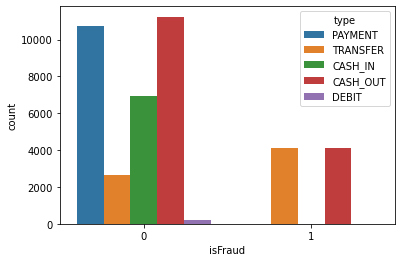

In [4]:
import seaborn as sns
sns.countplot(data=df, x="isFraud",hue="type")

In [5]:
#Encode catgorical feature of type as onehotcat

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
ohe= OneHotEncoder()

column_trans= make_column_transformer((OneHotEncoder(),['type']),remainder='passthrough')

In [6]:
column_trans.fit_transform(df)





array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.6538558e+05,
        6.5463324e+05, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [7]:
df['type']=column_trans.fit_transform(df)

In [8]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
5777870,400,0.0,65839.41,0.00,0.00,0.0,0.0,0
6362412,726,0.0,561446.32,561446.32,0.00,0.0,0.0,1
5927827,404,0.0,3828.08,10455.17,6627.09,0.0,0.0,0
5987904,410,0.0,557950.06,557950.06,0.00,0.0,0.0,1
5706694,398,0.0,1376.57,368349.14,366972.57,0.0,0.0,0


In [9]:
numerical= ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]

In [10]:
X= df.drop("isFraud",axis=1)
y= df["isFraud"]

In [11]:
#Normalize Numerical Features

from sklearn.preprocessing import StandardScaler
sc= StandardScaler()

X[numerical]= sc.fit_transform(X[numerical])



In [12]:
#Split dataset into test and training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [13]:
Define model

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [14]:
y_pred = dt.predict(X_test)

In [15]:
#Check the accuracy Score

from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

0.9904964361635613

## That's an accuracy of 99.04%

In [16]:
#Check the cross val score
from sklearn.model_selection import cross_val_score

cross_val_score(dt,X_train,y_train,cv=5,scoring='accuracy').mean()

0.9897773812875222

## That's a cross val score of 98.97%

# Trying other algorithms, Isolation forest and Local outlier Factor Algorithms

In [17]:
columns= df.columns.tolist()

print(df.columns.tolist())

['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']


In [18]:
columns=[c for c in columns if c not in ['isFraud']]
target ='isFraud'
print(columns)

['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


In [19]:
# X=df[columns]
# y=df[target]

print(len(y))

outlier_fraction = len(fraud)/float(len(not_fraud_sample))
print(outlier_fraction)
state= np.random.RandomState(2)

39985
0.25849804859624825


In [20]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [21]:
classifiers= {"IsolationForest":IsolationForest(n_estimators=100,max_samples=len(train_set),contamination= outlier_fraction,
                                                random_state=state, verbose=0),
             "LocalOutlierFactor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',leaf_size=30,metric='minkowski'),
             }





In [22]:
type(classifiers)

dict

In [23]:
n_outliers= len(fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if clf_name=="LocalOutlierFactor":
        y_pred = clf.fit_predict(X_train)
        score_prediction = clf.negative_outlier_factor_
    else:
        clf.fit(X_train)
        score_prediction= clf.decision_function(X_train)
        y_pred= clf.predict(X_train)
        
    #Reshape the prediction -- important , 0 for valid transactions, 1 for Fraud
    y_pred[y_pred==1]= 0
    y_pred[y_pred ==-1]= 1
    
    n_errors= (y_pred != y_train).sum()
    
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy score:")
    print(accuracy_score(y_train,y_pred))
    print("Classification Report: ")
    print(classification_report(y_train,y_pred))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest: 10914
Accuracy score:
0.6588095535825935
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.75      0.78     25443
           1       0.24      0.30      0.26      6545

    accuracy                           0.66     31988
   macro avg       0.52      0.52      0.52     31988
weighted avg       0.69      0.66      0.67     31988

LocalOutlierFactor: 13502
Accuracy score:
0.5779042140802801
Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.63      0.70     25443
           1       0.21      0.38      0.27      6545

    accuracy                           0.58     31988
   macro avg       0.50      0.50      0.49     31988
weighted avg       0.68      0.58      0.61     31988



## Isolation Forest and Local Outlier doesn't perform well because this data is downsampled.
